In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import multiprocessing

from sklearn.model_selection import train_test_split # Machine learning packages
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### Preparación de datos ( Ignorar :) )

In [9]:
column_names = ["bjets[0].Pt()", "bjets[1].Pt()", "bjets[2].Pt()", "bjets[3].Pt()", "(bjets[0].Eta() - bjets[1].Eta())", "(bjets[0].Eta() - bjets[2].Eta())", "(bjets[0].Eta() - bjets[3].Eta())", 
"(bjets[1].Eta() - bjets[2].Eta())", "(bjets[1].Eta() - bjets[3].Eta())", "(bjets[2].Eta() - bjets[3].Eta())", "bjets[0].DeltaPhi(bjets[1])", "bjets[0].DeltaPhi(bjets[2])", "bjets[0].DeltaPhi(bjets[3])", 
"bjets[1].DeltaPhi(bjets[2])", "bjets[1].DeltaPhi(bjets[3])", "bjets[2].DeltaPhi(bjets[3])","bjets[0].DeltaR(bjets[1])", "bjets[0].DeltaR(bjets[2])", "bjets[0].DeltaR(bjets[3])", 
"bjets[1].DeltaR(bjets[2])", "bjets[1].DeltaR(bjets[3])", "bjets[2].DeltaR(bjets[3])", "MET.Pt()", "np.sum(np.array(leptons)).Pt()", "(leptons_tot + MET).Mt()", "(bjets[0] + bjets[1]).M()", 
"(bjets[0] + bjets[2]).M()", "(bjets[0] + bjets[3]).M()", "(bjets[1] + bjets[2]).M()", "(bjets[1] + bjets[3]).M()", "(bjets[2] + bjets[3]).M()", "(bjets[0] + leptons_tot + MET).Mt()", 
"(bjets[1] + leptons_tot + MET).Mt()", "(bjets[2] + leptons_tot + MET).Mt()", "(bjets[3] + leptons_tot + MET).Mt()", "(jets[0] + jets[1]).M()", "jets[0].Pt()", "jets[1].Pt()", "jets[0].DeltaR(jets[1])",
 "bjets[0].DeltaR(leptons_tot)", "bjets[1].DeltaR(leptons_tot)", "bjets[2].DeltaR(leptons_tot)", "bjets[3].DeltaR(leptons_tot)", "bjets[0].DeltaPhi(leptons_tot)", "bjets[1].DeltaPhi(leptons_tot)", 
 "bjets[2].DeltaPhi(leptons_tot)", "bjets[3].DeltaPhi(leptons_tot)", "bjets[0].Phi", "bjets[1].Phi", "bjets[0].Eta", "bjets[1].Eta", "jets[0].Phi", "jets[1].Phi", "jets[0].Eta", "jets[1].Eta", 
 "leptons_tot.Phi", "leptons_tot.Eta", "class", "type"]

dfs1, dfs2, dfs3 = pd.read_csv("signal250.txt", names=column_names, sep=" "), pd.read_csv("signal350.txt", names=column_names, sep=" "), pd.read_csv("signal1000.txt", names=column_names, sep=" ")
dfb1, dfb2, dfb3 = pd.read_csv("bkg1.txt", names=column_names, sep=" "), pd.read_csv("bkg2.txt", names=column_names, sep=" "), pd.read_csv("bkg3.txt", names=column_names, sep=" ")

dfs1["class"], dfs2["class"], dfs3["class"], dfb1["class"], dfb2["class"], dfb3["class"] = 1, 1, 1, 0, 0, 0
dfs1["type"], dfs2["type"], dfs3["type"], dfb1["type"], dfb2["type"], dfb3["type"] = "sgn1", "sgn2", "sgn3", "bkg1", "bkg2", "bkg3"

df = pd.concat([dfs1, dfs2, dfs3, dfb1, dfb2, dfb3], ignore_index=True)

dataprime = pd.concat([df.iloc[:,:47], df.iloc[:,-2:]], axis=1)
s1 = dataprime.loc[dataprime["type"] == "sgn1"]
s2 = dataprime.loc[dataprime["type"] == "sgn2"]
s3 = dataprime.loc[dataprime["type"] == "sgn3"]
b1 = dataprime.loc[dataprime["type"] == "bkg1"]
b2 = dataprime.loc[dataprime["type"] == "bkg2"]
b3 = dataprime.loc[dataprime["type"] == "bkg3"]

frames1, frames2, frames3 = [s1, b1.iloc[:int(len(s1.index)/3.0), :], b2.iloc[:int(len(s1.index)/3.0), :], b3.iloc[:int(len(s1.index)/3.0), :]], [s2, b1.iloc[:int(len(s2.index)/3.0), :], b2.iloc[:int(len(s2.index)/3.0), :], b3.iloc[:int(len(s2.index)/3.0), :]], [s3, b1.iloc[:int(len(s3.index)/3.0), :], b2.iloc[:int(len(s3.index)/3.0), :], b3.iloc[:int(len(s3.index)/3.0), :]]

datap1, datap2, datap3 = pd.concat(frames1), pd.concat(frames2), pd.concat(frames3)

datap1

,bjets[0].Pt(),bjets[1].Pt(),bjets[2].Pt(),bjets[3].Pt(),(bjets[0].Eta() - bjets[1].Eta()),(bjets[0].Eta() - bjets[2].Eta()),(bjets[0].Eta() - bjets[3].Eta()),(bjets[1].Eta() - bjets[2].Eta()),(bjets[1].Eta() - bjets[3].Eta()),(bjets[2].Eta() - bjets[3].Eta()),...,bjets[0].DeltaR(leptons_tot),bjets[1].DeltaR(leptons_tot),bjets[2].DeltaR(leptons_tot),bjets[3].DeltaR(leptons_tot),bjets[0].DeltaPhi(leptons_tot),bjets[1].DeltaPhi(leptons_tot),bjets[2].DeltaPhi(leptons_tot),bjets[3].DeltaPhi(leptons_tot),class,type
0,85.790062,79.101341,76.226639,73.484489,-1.834188,-0.672529,-1.763499,1.161659,0.070688,-1.090971,...,2.651338,0.918119,1.369247,1.887533,2.073459,-0.899938,0.956414,1.884259,1,sgn1
1,199.395157,64.486130,57.019939,49.212360,-0.730201,0.452975,-1.372216,1.183176,-0.642015,-1.825191,...,0.707457,2.552826,0.794673,2.405341,0.238163,-2.137074,0.765543,-1.276979,1,sgn1
2,108.240120,107.411797,102.838387,40.021046,1.543365,-0.485863,-1.095197,-2.029228,-2.638563,-0.609334,...,1.069924,2.152137,2.105191,3.017604,1.017498,1.057904,-2.099474,-2.919185,1,sgn1
3,190.237045,96.510109,69.834419,63.006943,0.146976,-1.331831,0.458187,-1.478806,0.311212,1.790018,...,2.163157,2.493140,4.210813,2.640569,1.033992,-1.772724,2.699264,-2.212170,1,sgn1
4,221.238800,118.019905,56.416767,33.174603,1.265345,0.453719,1.305476,-0.811625,0.040131,0.851757,...,3.201904,2.018901,1.262092,2.237806,3.115782,-0.253111,-0.416616,-0.912963,1,sgn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97890,255.430542,122.749817,116.968292,110.687889,-1.704186,-1.900271,-1.173590,-0.196086,0.530596,0.726682,...,2.807700,2.004631,1.085945,0.517018,2.686027,-1.797910,0.084041,-0.374923,0,bkg3
97891,124.438179,65.141716,53.507172,52.842712,0.076654,-0.476945,-0.503437,-0.553599,-0.580090,-0.026491,...,1.920514,3.141797,2.038115,2.866478,1.750042,-3.059503,-1.595669,2.557550,0,bkg3
97892,78.006691,49.945076,46.788639,40.991722,2.558095,2.067611,1.586548,-0.490484,-0.971547,-0.481062,...,1.427355,2.232073,1.506408,1.872301,-1.068632,-1.544043,1.005878,1.759407,0,bkg3
97893,368.648376,149.937195,65.914497,33.615135,-1.843894,-1.221882,-0.370761,0.622013,1.473134,0.851121,...,2.069372,2.018015,2.317998,2.173683,-1.907863,1.727930,2.279556,2.130583,0,bkg3


### Separamos los datos de sus respectivas clases asociadas

In [10]:
data1, data2, data3 = datap1.iloc[:,:47], datap2.iloc[:,:47], datap3.iloc[:,:47]
target1, target2, target3 = datap1.iloc[:,-2], datap2.iloc[:,-2], datap3.iloc[:,-2]

### Separamos nuestros datos entre datos de entrenamiento (75%) y datos de prueba (25%)

In [11]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(data1, target1, test_size=0.25, random_state=0) # 0.25 significa 25% de los datos. Si es entero, representa numero de test samples
x_train2, x_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.25, random_state=0) # tambien se puede especificar el train_size
x_train3, x_test3, y_train3, y_test3 = train_test_split(data3, target3, test_size=0.25, random_state=0)

### Grid search para buscar los mejores valores de parámetros para el algoritmo de gradient boosting

In [12]:
"""
param_grid = {'n_estimators'  : [500, 1000],
              'max_depth'     : [None, 5, 10],
              'learning_rate' : [0.01, 0.1]
             }

grid = GridSearchCV(
        estimator  = GradientBoostingClassifier(random_state=123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = x_train3, y = y_train3)

print("Mejores hiperparámetros encontrados: ")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

final_model = grid.best_estimator_
"""

'\nparam_grid = {\'n_estimators\'  : [500, 1000],\n              \'max_depth\'     : [None, 5, 10],\n              \'learning_rate\' : [0.01, 0.1]\n             }\n\ngrid = GridSearchCV(\n        estimator  = GradientBoostingClassifier(random_state=123),\n        param_grid = param_grid,\n        scoring    = \'accuracy\',\n        n_jobs     = multiprocessing.cpu_count() - 1,\n        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), \n        refit      = True,\n        verbose    = 0,\n        return_train_score = True\n       )\n\ngrid.fit(X = x_train3, y = y_train3)\n\nprint("Mejores hiperparámetros encontrados: ")\nprint(grid.best_params_, ":", grid.best_score_, grid.scoring)\n\nfinal_model = grid.best_estimator_\n'

### Entrenamos los tres modelos

In [13]:
gb3 = GradientBoostingClassifier(n_estimators=250, max_depth=7, learning_rate=0.1) # n_estimators = numero de etapas de boosting. Entre más grande, mejor ya que es un algoritmo robusto frente a over-fitting. Ver: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
gb3.fit(x_train1, y_train1) # max_depth: Profundidad maxima del arbol. learning_rate: valor de lambda en el metodo de gradiente descendente

GradientBoostingClassifier(max_depth=7, n_estimators=250)

### Encontramos valores de precision y recall

In [14]:
predictions3 = gb3.predict(x_test3)

precision3  = precision_score(y_test3, predictions3, average='micro')

recall3 = recall_score(y_test3, predictions3, average='micro')

print("The precision for the third model is: ", precision3)
print("\n")
print("The recall for the third model is: ", recall3)

The precision for the third model is:  0.6566274762441617


The recall for the third model is:  0.6566274762441617


### Encontramos las matrices de confusion

Confusion matrix for the third model is: 
[[2615  490]
 [1642 1462]]


Text(0.5, 1.0, 'Score: 0.657')

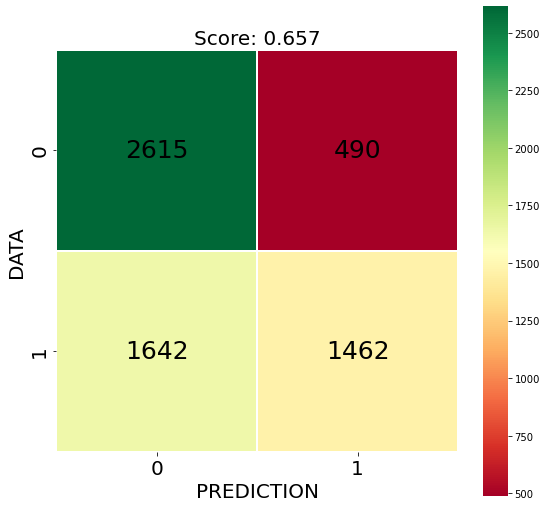

In [15]:
cm3 = metrics.confusion_matrix(y_test3, predictions3) 
print("Confusion matrix for the third model is: ")
print(cm3)

plt.figure(figsize=(9,9))
sns.heatmap(cm3, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = "RdYlGn", cbar=True, annot_kws={"fontsize":25, "color":"k"})
plt.ylabel('DATA', fontsize=20)
plt.xlabel('PREDICTION', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
all_sample_title = 'Score: {0}'.format(format(recall3, ".3f"))
plt.title(all_sample_title, size = 20)

### Importancia de cada variable (solo para tercer modelo)

In [16]:
importance3 = gb3.feature_importances_

for i,s in enumerate(importance3):
    print('Feature: %0s, Score: %.5f' % (column_names[i],s))

Feature: bjets[0].Pt(), Score: 0.04761
Feature: bjets[1].Pt(), Score: 0.01963
Feature: bjets[2].Pt(), Score: 0.02134
Feature: bjets[3].Pt(), Score: 0.02250
Feature: (bjets[0].Eta() - bjets[1].Eta()), Score: 0.01453
Feature: (bjets[0].Eta() - bjets[2].Eta()), Score: 0.01432
Feature: (bjets[0].Eta() - bjets[3].Eta()), Score: 0.01341
Feature: (bjets[1].Eta() - bjets[2].Eta()), Score: 0.01396
Feature: (bjets[1].Eta() - bjets[3].Eta()), Score: 0.01240
Feature: (bjets[2].Eta() - bjets[3].Eta()), Score: 0.01285
Feature: bjets[0].DeltaPhi(bjets[1]), Score: 0.01637
Feature: bjets[0].DeltaPhi(bjets[2]), Score: 0.01331
Feature: bjets[0].DeltaPhi(bjets[3]), Score: 0.01606
Feature: bjets[1].DeltaPhi(bjets[2]), Score: 0.01591
Feature: bjets[1].DeltaPhi(bjets[3]), Score: 0.01516
Feature: bjets[2].DeltaPhi(bjets[3]), Score: 0.01785
Feature: bjets[0].DeltaR(bjets[1]), Score: 0.03352
Feature: bjets[0].DeltaR(bjets[2]), Score: 0.02090
Feature: bjets[0].DeltaR(bjets[3]), Score: 0.01833
Feature: bjets[1].D

<BarContainer object of 47 artists>

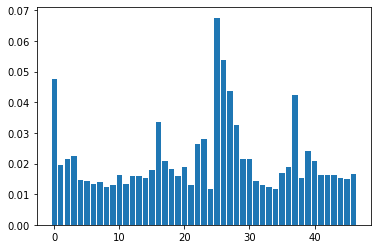

In [17]:
plt.bar([x for x in range(len(importance3))], importance3)